# Đề tài: Mô hình dự đoán về mức giá điện dựa trên mức tiêu thụ năng lượng điện được dự đoán thông qua các yếu tố khách quan

## Các thành viên: 
## + Bùi Minh Mạnh - 22000105 (Nhóm trưởng)
## + Trịnh Đức Huy - 22000097
## + Dương Đạt Khang - 22000099

## Tiền xử lý dữ liệu

### weather_features.csv

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu
df = pd.read_csv('weather_features.csv')

# Hiển thị thông tin cơ bản về dữ liệu
print(f"Số lượng bản ghi: {df.shape[0]}")
print(f"Số lượng thuộc tính: {df.shape[1]}")
print("\nCác cột trong dữ liệu:")
print(df.columns.tolist())
print("\nThông tin chi tiết về dữ liệu:")
print(df.info())
print("\nThống kê mô tả cho các biến số:")
print(df.describe())

Số lượng bản ghi: 178396
Số lượng thuộc tính: 17

Các cột trong dữ liệu:
['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all', 'weather_id', 'weather_main', 'weather_description', 'weather_icon']

Thông tin chi tiết về dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 

Kiểm tra dữ liệu lỗi

In [20]:
# Kiểm tra giá trị thiếu
print("Số lượng giá trị thiếu trong mỗi cột:")
print(df.isnull().sum())

# Kiểm tra các giá trị trùng lặp
print(f"\nSố lượng bản ghi trùng lặp: {df.duplicated().sum()}")

# Kiểm tra các giá trị ngoại lệ cho các cột số
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    if outliers > 0:
        print(f"Cột {col} có {outliers} giá trị ngoại lệ")

# Kiểm tra giá trị không hợp lệ cho các trường quan trọng
print("\nGiá trị không hợp lệ:")
print(f"- Nhiệt độ âm (K): {(df['temp'] < 0).sum()}")
print(f"- Độ ẩm > 100% hoặc < 0%: {((df['humidity'] > 100) | (df['humidity'] < 0)).sum()}")

Số lượng giá trị thiếu trong mỗi cột:
dt_iso                 0
city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

Số lượng bản ghi trùng lặp: 21
Cột temp có 196 giá trị ngoại lệ
Cột temp_min có 290 giá trị ngoại lệ
Cột temp_max có 391 giá trị ngoại lệ
Cột pressure có 11830 giá trị ngoại lệ
Cột humidity có 63 giá trị ngoại lệ
Cột wind_speed có 2425 giá trị ngoại lệ
Cột rain_1h có 19388 giá trị ngoại lệ
Cột rain_3h có 1855 giá trị ngoại lệ
Cột snow_3h có 267 giá trị ngoại lệ
Cột weather_id có 47665 giá trị ngoại lệ

Giá trị không hợp lệ:
- Nhiệt độ âm (K): 0
- Độ ẩm > 100% hoặc < 0%: 0


In [21]:
# Loại bỏ các bản ghi trùng lặp
df = df.drop_duplicates().reset_index(drop=True)
print(f"Số lượng bản ghi sau khi loại bỏ trùng lặp: {df.shape[0]}")

# Chuyển đổi cột dt_iso sang kiểu datetime với xử lý lỗi
df['dt_iso'] = pd.to_datetime(df['dt_iso'], utc=True, errors='coerce')

# Tạo các biến thời gian
df['dt_iso'] = pd.to_datetime(df['dt_iso'], utc=True)
df['day'] = df['dt_iso'].dt.day
df['month'] = df['dt_iso'].dt.month
df['day_of_week'] = df['dt_iso'].dt.dayofweek

# Chuyển đổi nhiệt độ từ Kelvin sang Celsius
df['temp_C'] = df['temp'] - 273.15
df['temp_min_C'] = df['temp_min'] - 273.15
df['temp_max_C'] = df['temp_max'] - 273.15

# Xử lý giá trị ngoại lệ cho wind_speed - giới hạn ở các cơn gió rất mạnh (>64 m/s là bão cấp 5)
wind_speed_cap = 64
df.loc[df['wind_speed'] > wind_speed_cap, 'wind_speed'] = wind_speed_cap

Số lượng bản ghi sau khi loại bỏ trùng lặp: 178375


In [22]:
df['hour'] = df['dt_iso'].dt.hour

# Chuyển đổi dữ liệu phân loại sang one-hot encoding
# Để dữ liệu không phình to quá nhiều, tôi sẽ chỉ chuyển các biến phân loại quan trọng
categorical_cols = ['weather_main']
df_encoded = pd.get_dummies(df, columns=categorical_cols, prefix=categorical_cols)

# Mã hóa hướng gió thành dạng cyclic feature
df_encoded['wind_sin'] = np.sin(np.radians(df['wind_deg']))
df_encoded['wind_cos'] = np.cos(np.radians(df['wind_deg']))

# Mã hóa biến thời gian thành dạng cyclic
df_encoded['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df_encoded['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
df_encoded['day_sin'] = np.sin(2 * np.pi * df['day']/31)
df_encoded['day_cos'] = np.cos(2 * np.pi * df['day']/31)
df_encoded['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df_encoded['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df_encoded['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
df_encoded['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

print(f"Số lượng thuộc tính sau khi chuyển đổi: {df_encoded.shape[1]}")
print("\nCác cột sau khi chuyển đổi:")
print(df_encoded.columns.tolist())

Số lượng thuộc tính sau khi chuyển đổi: 45

Các cột sau khi chuyển đổi:
['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all', 'weather_id', 'weather_description', 'weather_icon', 'day', 'month', 'day_of_week', 'temp_C', 'temp_min_C', 'temp_max_C', 'hour', 'weather_main_clear', 'weather_main_clouds', 'weather_main_drizzle', 'weather_main_dust', 'weather_main_fog', 'weather_main_haze', 'weather_main_mist', 'weather_main_rain', 'weather_main_smoke', 'weather_main_snow', 'weather_main_squall', 'weather_main_thunderstorm', 'wind_sin', 'wind_cos', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos']


In [23]:
# Chọn các biến số cần chuẩn hóa
numeric_features = ['pressure', 'humidity', 'wind_speed', 'clouds_all', 'rain_1h', 'rain_3h', 'snow_3h']

# Chuẩn hóa các biến số về dạng 0-1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_encoded[numeric_features] = scaler.fit_transform(df_encoded[numeric_features])

# Hiển thị thống kê của dữ liệu sau khi chuẩn hóa
print("\nThống kê mô tả sau khi chuẩn hóa:")
print(df_encoded[numeric_features].describe())


Thống kê mô tả sau khi chuẩn hóa:
            pressure       humidity     wind_speed     clouds_all  \
count  178375.000000  178375.000000  178375.000000  178375.000000   
mean        0.001060       0.684227       0.038598       0.250753   
std         0.005920       0.219035       0.032471       0.307749   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.001005       0.530000       0.015625       0.000000   
50%         0.001010       0.720000       0.031250       0.200000   
75%         0.001014       0.870000       0.062500       0.400000   
max         1.000000       1.000000       1.000000       1.000000   

             rain_1h        rain_3h        snow_3h  
count  178375.000000  178375.000000  178375.000000  
mean        0.006292       0.000164       0.000222  
std         0.033239       0.003147       0.010354  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000     


Tổng số thuộc tính đầu vào: 27
Số lượng mẫu dữ liệu: 178375
Biến mục tiêu: temp_C


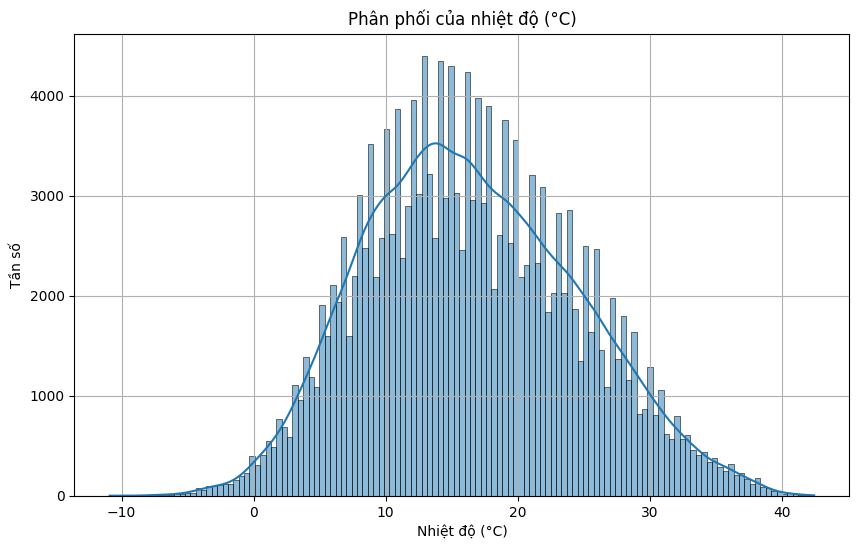

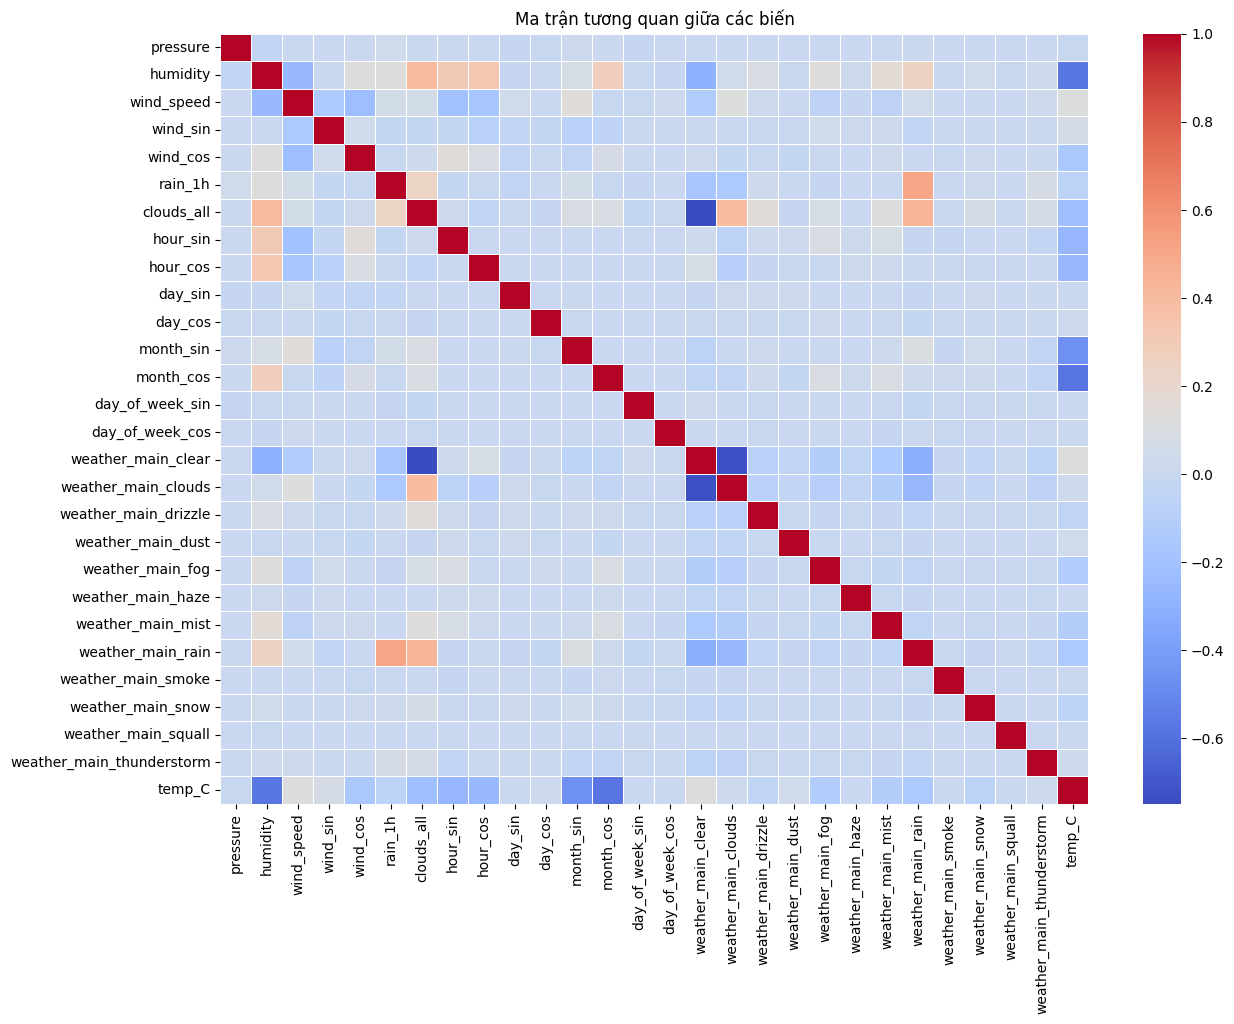


Tổng kết dữ liệu sau tiền xử lý:
- Số lượng mẫu: 178375
- Số lượng thuộc tính: 27
- Dạng của biến mục tiêu: Số liên tục (nhiệt độ °C)
- Các thuộc tính quan trọng: pressure, humidity, wind_speed, clouds_all, rain_1h
- Các thuộc tính phái sinh: biến thời gian theo dạng cyclic, wind_sin, wind_cos
- Các biến phân loại đã được chuyển đổi: weather_main


In [24]:
# Lựa chọn các cột quan trọng cho mô hình
selected_features = [
    'pressure', 'humidity', 'wind_speed', 'wind_sin', 'wind_cos',
    'rain_1h', 'clouds_all', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 
    'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos'
]

# Thêm các cột weather_main đã được chuyển đổi
weather_main_cols = [col for col in df_encoded.columns if 'weather_main_' in col]
selected_features.extend(weather_main_cols)

# Chọn biến mục tiêu là nhiệt độ (đã chuyển sang độ C)
target = 'temp_C'

# Dữ liệu cuối cùng
X = df_encoded[selected_features]
y = df_encoded[target]

print(f"\nTổng số thuộc tính đầu vào: {X.shape[1]}")
print(f"Số lượng mẫu dữ liệu: {X.shape[0]}")
print(f"Biến mục tiêu: {target}")

# Vẽ biểu đồ phân phối của biến mục tiêu
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True)
plt.title('Phân phối của nhiệt độ (°C)')
plt.xlabel('Nhiệt độ (°C)')
plt.ylabel('Tần số')
plt.grid(True)
plt.show()

# Vẽ biểu đồ tương quan
plt.figure(figsize=(14, 10))
correlation_matrix = df_encoded[selected_features + [target]].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Ma trận tương quan giữa các biến')
plt.show()

# Tổng kết
print("\nTổng kết dữ liệu sau tiền xử lý:")
print(f"- Số lượng mẫu: {X.shape[0]}")
print(f"- Số lượng thuộc tính: {X.shape[1]}")
print(f"- Dạng của biến mục tiêu: Số liên tục (nhiệt độ °C)")
print("- Các thuộc tính quan trọng: pressure, humidity, wind_speed, clouds_all, rain_1h")
print("- Các thuộc tính phái sinh: biến thời gian theo dạng cyclic, wind_sin, wind_cos")
print("- Các biến phân loại đã được chuyển đổi: weather_main")

### energy_dataset.csv

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu
energy_df = pd.read_csv('energy_dataset.csv')

# Hiển thị thông tin cơ bản về dữ liệu
print(f"Số lượng bản ghi: {energy_df.shape[0]}")
print(f"Số lượng thuộc tính: {energy_df.shape[1]}")
print("\nCác cột trong dữ liệu:")
print(energy_df.columns.tolist())
print("\nThông tin chi tiết về dữ liệu:")
print(energy_df.info())
print("\nThống kê mô tả cho các biến số:")
print(energy_df.describe())

Số lượng bản ghi: 35064
Số lượng thuộc tính: 29

Các cột trong dữ liệu:
['time', 'generation biomass', 'generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation marine', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore', 'forecast solar day ahead', 'forecast wind offshore eday ahead', 'forecast wind onshore day ahead', 'total load forecast', 'total load actual', 'price day ahead', 'price actual']

Thông tin chi tiết về dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data c

In [26]:
# Kiểm tra giá trị thiếu
print("Số lượng giá trị thiếu trong mỗi cột:")
print(energy_df.isnull().sum())

# Kiểm tra các giá trị trùng lặp
print(f"\nSố lượng bản ghi trùng lặp: {energy_df.duplicated().sum()}")

# Kiểm tra các giá trị ngoại lệ cho các cột số
numeric_cols = energy_df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    Q1 = energy_df[col].quantile(0.25)
    Q3 = energy_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((energy_df[col] < lower_bound) | (energy_df[col] > upper_bound)).sum()
    if outliers > 0:
        print(f"Cột {col} có {outliers} giá trị ngoại lệ")

Số lượng giá trị thiếu trong mỗi cột:
time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generati

In [27]:
# Loại bỏ các bản ghi trùng lặp
energy_df = energy_df.drop_duplicates().reset_index(drop=True)
print(f"Số lượng bản ghi sau khi loại bỏ trùng lặp: {energy_df.shape[0]}")

# Chuyển đổi cột time sang kiểu datetime với xử lý lỗi
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True)

# Trích xuất các biến thời gian
energy_df['hour'] = energy_df['time'].dt.hour
energy_df['day'] = energy_df['time'].dt.day
energy_df['month'] = energy_df['time'].dt.month
energy_df['day_of_week'] = energy_df['time'].dt.dayofweek

# Xử lý dữ liệu thiếu - điền giá trị thiếu bằng giá trị trung bình
numeric_cols = energy_df.select_dtypes(include=['float64', 'int64']).columns
energy_df[numeric_cols] = energy_df[numeric_cols].fillna(energy_df[numeric_cols].mean())

# Kiểm tra giá trị thiếu sau khi xử lý
print(f"Số lượng giá trị thiếu sau khi xử lý: {energy_df.isnull().sum().sum()}")

Số lượng bản ghi sau khi loại bỏ trùng lặp: 35064
Số lượng giá trị thiếu sau khi xử lý: 70128


In [28]:
# Mã hóa biến cyclic cho thời gian
energy_df['hour_sin'] = np.sin(2 * np.pi * energy_df['hour']/24)
energy_df['hour_cos'] = np.cos(2 * np.pi * energy_df['hour']/24)
energy_df['day_sin'] = np.sin(2 * np.pi * energy_df['day']/31)
energy_df['day_cos'] = np.cos(2 * np.pi * energy_df['day']/31)
energy_df['month_sin'] = np.sin(2 * np.pi * energy_df['month']/12)
energy_df['month_cos'] = np.cos(2 * np.pi * energy_df['month']/12)
energy_df['day_of_week_sin'] = np.sin(2 * np.pi * energy_df['day_of_week']/7)
energy_df['day_of_week_cos'] = np.cos(2 * np.pi * energy_df['day_of_week']/7)

# Thêm các tính năng phái sinh có ý nghĩa
energy_df['total_fossil'] = energy_df['generation fossil brown coal/lignite'] + \
                           energy_df['generation fossil coal-derived gas'] + \
                           energy_df['generation fossil gas'] + \
                           energy_df['generation fossil hard coal'] + \
                           energy_df['generation fossil oil'] + \
                           energy_df['generation fossil oil shale'] + \
                           energy_df['generation fossil peat']

energy_df['total_renewable'] = energy_df['generation hydro pumped storage aggregated'] + \
                              energy_df['generation hydro run-of-river and poundage'] + \
                              energy_df['generation hydro water reservoir'] + \
                              energy_df['generation solar'] + \
                              energy_df['generation wind offshore'] + \
                              energy_df['generation wind onshore'] + \
                              energy_df['generation biomass'] + \
                              energy_df['generation other renewable']

print(f"Số lượng thuộc tính sau khi thêm biến mới: {energy_df.shape[1]}")
print("\nCác cột sau khi biến đổi:")
print(energy_df.columns.tolist())

Số lượng thuộc tính sau khi thêm biến mới: 43

Các cột sau khi biến đổi:
['time', 'generation biomass', 'generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation marine', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore', 'forecast solar day ahead', 'forecast wind offshore eday ahead', 'forecast wind onshore day ahead', 'total load forecast', 'total load actual', 'price day ahead', 'price actual', 'hour', 'day', 'month', 'day_of_week', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'd

In [29]:
# Chọn các biến số cần chuẩn hóa
numeric_features = ['total load forecast', 'total load actual', 
                    'generation biomass', 'generation fossil brown coal/lignite',
                    'generation fossil coal-derived gas', 'generation fossil gas',
                    'generation fossil hard coal', 'generation fossil oil',
                    'generation nuclear', 'generation solar',
                    'generation wind offshore', 'generation wind onshore',
                    'total_fossil', 'total_renewable']

# Chuẩn hóa các biến số về dạng 0-1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
energy_df[numeric_features] = scaler.fit_transform(energy_df[numeric_features])

# Hiển thị thống kê của dữ liệu sau khi chuẩn hóa
print("\nThống kê mô tả sau khi chuẩn hóa:")
print(energy_df[numeric_features].describe())


Thống kê mô tả sau khi chuẩn hóa:
       total load forecast  total load actual  generation biomass  \
count         35064.000000       35064.000000        35064.000000   
mean              0.455535           0.463826            0.647827   
std               0.197299           0.199035            0.144140   
min               0.000000           0.000000            0.000000   
25%               0.287256           0.294637            0.562500   
50%               0.463861           0.472404            0.619932   
75%               0.608042           0.615707            0.731419   
max               1.000000           1.000000            1.000000   

       generation fossil brown coal/lignite  \
count                          35064.000000   
mean                               0.448508   
std                                0.354832   
min                                0.000000   
25%                                0.000000   
50%                                0.509510   
75%           

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\_array_api.py:695: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\_array_api.py:712: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


In [30]:
# Lựa chọn các cột quan trọng cho mô hình
selected_energy_features = [
    'total load forecast', 'total load actual', 
    'total_fossil', 'total_renewable',
    'generation nuclear', 'generation solar', 'generation wind onshore',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos'
]

# Chọn biến mục tiêu
target = 'price actual'

# Dữ liệu cuối cùng
X_energy = energy_df[selected_energy_features]
y_energy = energy_df[target]

Missing values in total_renewable before fixing: 35064
Missing values in total_renewable after fixing: 0
Final check - missing values in X_energy: 0

Tổng số thuộc tính đầu vào: 15
Số lượng mẫu dữ liệu: 35064
Biến mục tiêu: price actual


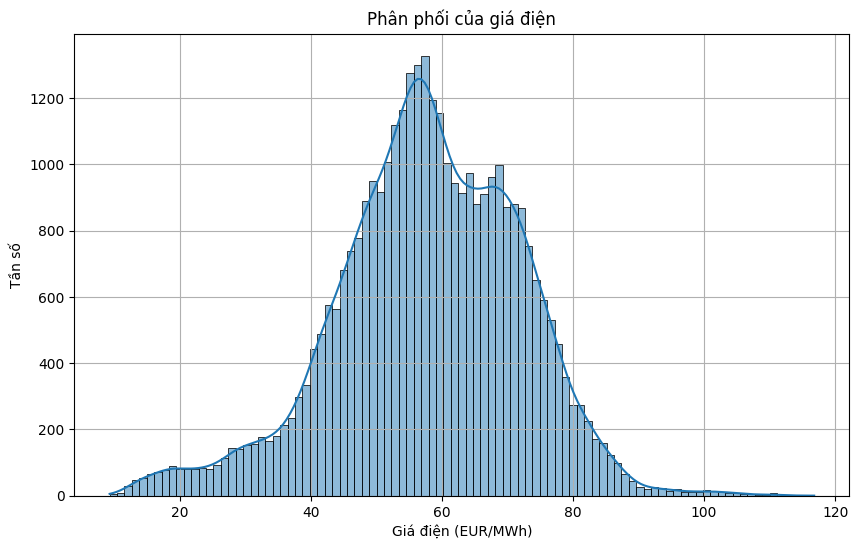

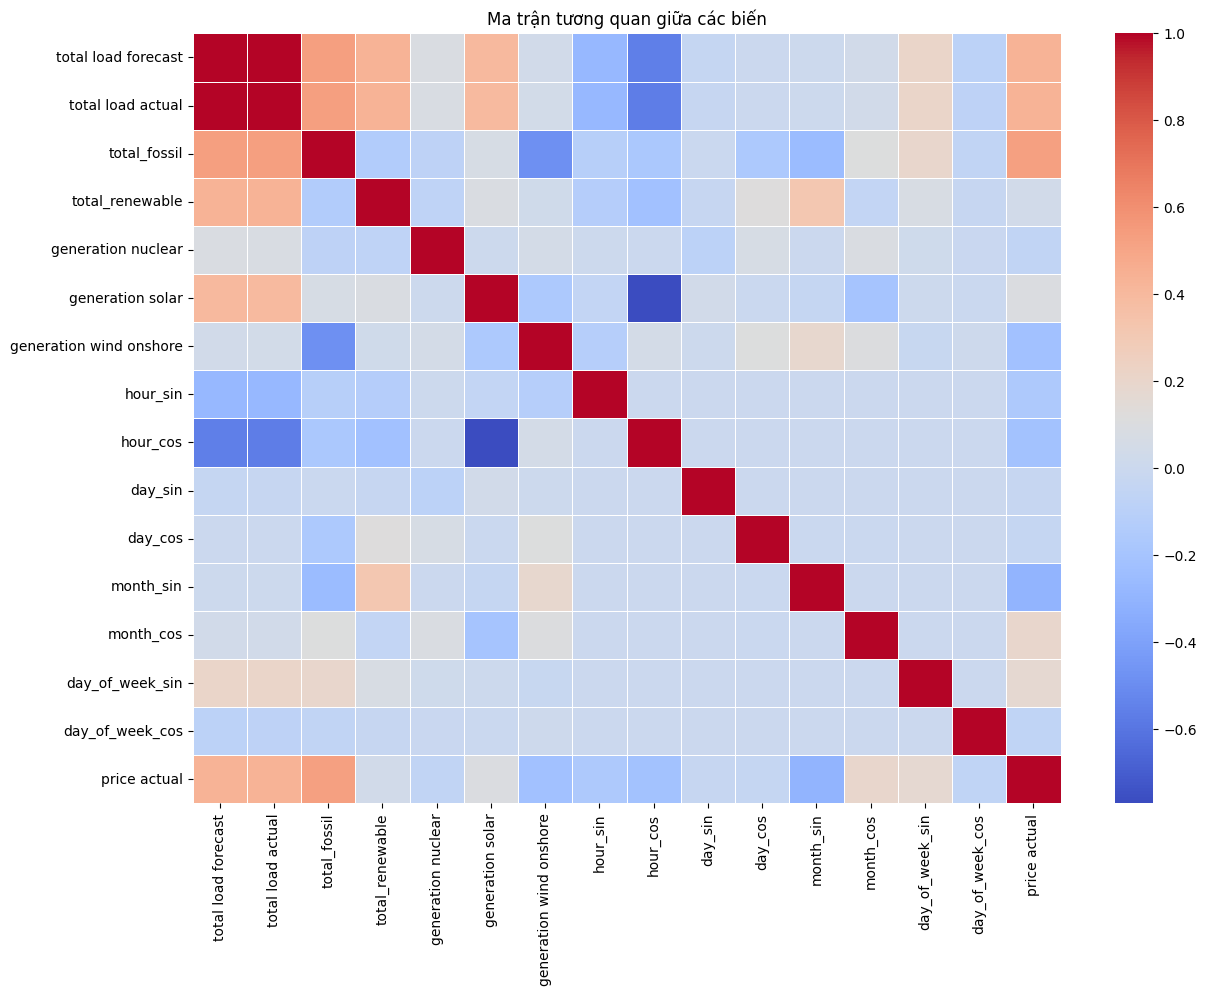


Tổng kết dữ liệu energy_dataset sau tiền xử lý:
- Số lượng mẫu: 35064
- Số lượng thuộc tính: 15
- Dạng của biến mục tiêu: Số liên tục (giá điện EUR/MWh)
- Các thuộc tính quan trọng: total_load_actual, total_fossil, total_renewable
- Các thuộc tính phái sinh: biến thời gian theo dạng cyclic
- Các biến tổng hợp: total_fossil, total_renewable


In [31]:
# Check for NaN values in total_renewable column
print("Missing values in total_renewable before fixing:", energy_df['total_renewable'].isna().sum())

# Fix missing values in total_renewable
# Option 1: Fill with mean if only some values are missing
#energy_df['total_renewable'] = energy_df['total_renewable'].fillna(energy_df['total_renewable'].mean())

# Option 2: If that doesn't work (e.g., all values are NaN), recalculate the column
# First ensure all component columns have no NaNs
renewable_columns = [
    'generation hydro pumped storage aggregated',
    'generation hydro run-of-river and poundage',
    'generation hydro water reservoir',
    'generation solar',
    'generation wind offshore',
    'generation wind onshore',
    'generation biomass',
    'generation other renewable'
]

# Fill NaNs in component columns with zeros or means
for col in renewable_columns:
    if col in energy_df.columns:
        energy_df[col] = energy_df[col].fillna(energy_df[col].mean())

# Recalculate total_renewable
energy_df['total_renewable'] = energy_df[renewable_columns].sum(axis=1)

# Verify the fix
print("Missing values in total_renewable after fixing:", energy_df['total_renewable'].isna().sum())

# Update the X_energy dataframe if total_renewable is included
if 'total_renewable' in selected_energy_features:
    X_energy = energy_df[selected_energy_features]
    
# Re-apply normalization if needed
if 'total_renewable' in numeric_features:
    # Normalize just the total_renewable column
    scaler = MinMaxScaler()
    energy_df['total_renewable'] = scaler.fit_transform(energy_df[['total_renewable']])
    
    # Update X_energy after normalization
    if 'total_renewable' in selected_energy_features:
        X_energy = energy_df[selected_energy_features]

print("Final check - missing values in X_energy:", X_energy.isna().sum().sum())

print(f"\nTổng số thuộc tính đầu vào: {X_energy.shape[1]}")
print(f"Số lượng mẫu dữ liệu: {X_energy.shape[0]}")
print(f"Biến mục tiêu: {target}")

# Vẽ biểu đồ phân phối của biến mục tiêu
plt.figure(figsize=(10, 6))
sns.histplot(y_energy, kde=True)
plt.title('Phân phối của giá điện')
plt.xlabel('Giá điện (EUR/MWh)')
plt.ylabel('Tần số')
plt.grid(True)
plt.show()

# Vẽ biểu đồ tương quan
plt.figure(figsize=(14, 10))
correlation_matrix = energy_df[selected_energy_features + [target]].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Ma trận tương quan giữa các biến')
plt.show()

# Tổng kết
print("\nTổng kết dữ liệu energy_dataset sau tiền xử lý:")
print(f"- Số lượng mẫu: {X_energy.shape[0]}")
print(f"- Số lượng thuộc tính: {X_energy.shape[1]}")
print(f"- Dạng của biến mục tiêu: Số liên tục (giá điện EUR/MWh)")
print("- Các thuộc tính quan trọng: total_load_actual, total_fossil, total_renewable")
print("- Các thuộc tính phái sinh: biến thời gian theo dạng cyclic")
print("- Các biến tổng hợp: total_fossil, total_renewable")

## Phân tích và trực quan hóa dữ liệu

In [32]:
# Phân tích thống kê của dữ liệu weather
print("===== PHÂN TÍCH THỐNG KÊ DỮ LIỆU WEATHER =====")

# Ensure we're using the variables correctly from previous cells
# df_encoded was created in cell 8 and X was defined in cell 10
print("\nThống kê mô tả cho các thuộc tính đã chọn:")
print(X.describe())

# Phân tích thống kê của dữ liệu energy
print("\n\n===== PHÂN TÍCH THỐNG KÊ DỮ LIỆU ENERGY =====")
print("\nThống kê mô tả cho các thuộc tính đã chọn:")
print(X_energy.describe())

# Tính ma trận hiệp phương sai cho cả hai tập dữ liệu
cov_matrix_weather = X.cov()
cov_matrix_energy = X_energy.cov()

print("\nMa trận hiệp phương sai cho dữ liệu weather (5x5 đầu tiên):")
print(cov_matrix_weather.iloc[:5, :5])

print("\nMa trận hiệp phương sai cho dữ liệu energy (5x5 đầu tiên):")
print(cov_matrix_energy.iloc[:5, :5])

===== PHÂN TÍCH THỐNG KÊ DỮ LIỆU WEATHER =====

Thống kê mô tả cho các thuộc tính đã chọn:
            pressure       humidity     wind_speed       wind_sin  \
count  178375.000000  178375.000000  178375.000000  178375.000000   
mean        0.001060       0.684227       0.038598      -0.073912   
std         0.005920       0.219035       0.032471       0.672549   
min         0.000000       0.000000       0.000000      -1.000000   
25%         0.001005       0.530000       0.015625      -0.731354   
50%         0.001010       0.720000       0.031250       0.000000   
75%         0.001014       0.870000       0.062500       0.601815   
max         1.000000       1.000000       1.000000       1.000000   

            wind_cos        rain_1h     clouds_all      hour_sin  \
count  178375.000000  178375.000000  178375.000000  1.783750e+05   
mean        0.153402       0.006292       0.250753  2.603329e-03   
std         0.720200       0.033239       0.307749  7.076131e-01   
min        -1.0

Gộp dữ liệu

In [33]:
df_encoded.rename(columns={'dt_iso': 'time'}, inplace=True)
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True)
df_merged = pd.merge(energy_df, df_encoded, on='time', how='inner', suffixes=('_energy', '_weather'))
df_merged['time_numeric'] = (df_merged['time'] - df_merged['time'].min()).dt.total_seconds()

# Check what columns are actually available
print("Available columns in merged dataframe:")
print(df_merged.columns.tolist())

Available columns in merged dataframe:
['time', 'generation biomass', 'generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation marine', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore', 'forecast solar day ahead', 'forecast wind offshore eday ahead', 'forecast wind onshore day ahead', 'total load forecast', 'total load actual', 'price day ahead', 'price actual', 'hour_energy', 'day_energy', 'month_energy', 'day_of_week_energy', 'hour_sin_energy', 'hour_cos_energy', 'day_sin_energy', 'day_cos_energy', 'month

In [34]:
# Updated merged features with correct column names
merged_features = [
    'total load actual',   # From energy dataset
    'total_fossil',        # From energy dataset 
    'total_renewable',     # From energy dataset
    'temp_C',              # From weather dataset
    'humidity',            # From weather dataset
    'wind_speed',          # From weather dataset
    
    # Choose one set of time features (using energy dataset's)
    'hour_sin_energy',     
    'hour_cos_energy',     
    'month_sin_energy',    
    'month_cos_energy'     
]

# Create a clean subset of the merged data
df_merged_clean = df_merged[merged_features].copy()

Giảm chiều bằng PCA

In [35]:
from cuml.preprocessing import StandardScaler
from cuml.decomposition import PCA
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Xử lý NaN
df_numeric = df_merged_clean.select_dtypes(include=[np.number])
df_numeric = df_numeric.fillna(df_numeric.mean())

# Loại bỏ cột có phương sai = 0
df_numeric = df_numeric.loc[:, df_numeric.std() != 0]
df_numeric = df_numeric.dropna(axis=1)

print(f"Số cột sau khi loại bỏ các cột phương sai 0: {df_numeric.shape[1]}")

# Convert to float32 for GPU compatibility
df_numeric = df_numeric.astype(np.float32)

# Chuẩn hóa
scaler = StandardScaler()
data_for_pca = scaler.fit_transform(df_numeric)

# PCA
pca = PCA()
pca.fit(data_for_pca)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Số thành phần chính giữ ≥95% phương sai: {n_components_95}")

data_pca = pca.transform(data_for_pca)

# Convert back to host memory for visualization if necessary
# Handle different types of return values safely
if not isinstance(data_pca, np.ndarray):
    try:
        # Try cuML GPU array approach
        if hasattr(data_pca, 'get') and callable(getattr(data_pca, 'get')):
            data_pca = data_pca.get()
        else:
            # Convert to numpy array for other types
            data_pca = np.array(data_pca)
    except:
        # Fallback to numpy conversion
        data_pca = np.array(data_pca)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c='blue', s=10)
plt.title("Dữ liệu sau khi giảm chiều bằng PCA")
plt.xlabel("Thành phần chính 1")
plt.ylabel("Thành phần chính 2")
plt.grid(True)
plt.show()

# Biểu diễn tỷ lệ phương sai giải thích được
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), 
         cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Số lượng thành phần chính')
plt.ylabel('Tỷ lệ phương sai tích lũy')
plt.title('Tỷ lệ phương sai tích lũy theo số lượng thành phần chính')
plt.axhline(y=0.95, color='r', linestyle='--', label='Ngưỡng 95%')
plt.axvline(x=n_components_95, color='g', linestyle='--', 
           label=f'{n_components_95} thành phần')
plt.grid(True)
plt.legend()
plt.show()

ModuleNotFoundError: No module named 'cuml'

Số cột sau khi loại bỏ các cột phương sai 0: 10
Số thành phần chính giữ ≥95% phương sai: 8


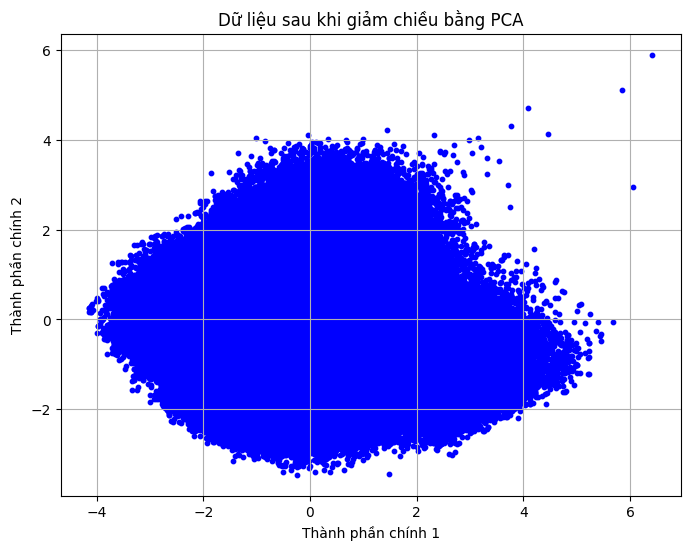

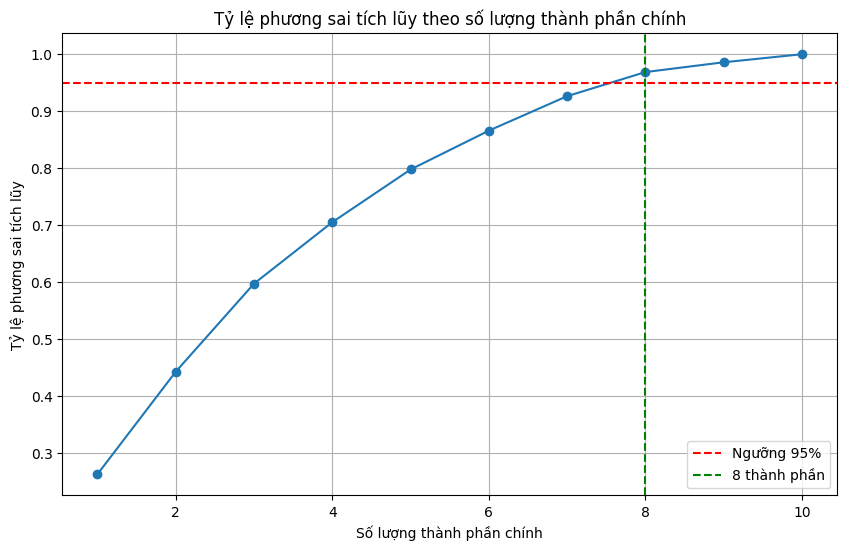

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Xử lý NaN
df_numeric = df_merged_clean.select_dtypes(include=[np.number])
df_numeric = df_numeric.fillna(df_numeric.mean())

# Loại bỏ cột có phương sai = 0
df_numeric = df_numeric.loc[:, df_numeric.std() != 0]
df_numeric = df_numeric.dropna(axis=1)

print(f"Số cột sau khi loại bỏ các cột phương sai 0: {df_numeric.shape[1]}")

# Chuẩn hóa (no need for float32 conversion with sklearn)
scaler = StandardScaler()
data_for_pca = scaler.fit_transform(df_numeric)

# PCA
pca = PCA()
pca.fit(data_for_pca)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Số thành phần chính giữ ≥95% phương sai: {n_components_95}")

data_pca = pca.transform(data_for_pca)

# Plot (sklearn always returns numpy arrays so no conversion needed)
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c='blue', s=10)
plt.title("Dữ liệu sau khi giảm chiều bằng PCA")
plt.xlabel("Thành phần chính 1")
plt.ylabel("Thành phần chính 2")
plt.grid(True)
plt.show()

# Biểu diễn tỷ lệ phương sai giải thích được
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), 
         cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Số lượng thành phần chính')
plt.ylabel('Tỷ lệ phương sai tích lũy')
plt.title('Tỷ lệ phương sai tích lũy theo số lượng thành phần chính')
plt.axhline(y=0.95, color='r', linestyle='--', label='Ngưỡng 95%')
plt.axvline(x=n_components_95, color='g', linestyle='--', 
           label=f'{n_components_95} thành phần')
plt.grid(True)
plt.legend()
plt.show()

Giảm chiều bằng t-SNE

Running t-SNE on merged dataset...
Data types in MERGED dataset:
total load actual    float64
total_fossil         float64
total_renewable      float64
temp_C               float64
humidity             float64
wind_speed           float64
hour_sin_energy      float64
hour_cos_energy      float64
month_sin_energy     float64
month_cos_energy     float64
dtype: object
TSNE result shape for perplexity 5: (178375, 2)
[2025-04-19 21:36:32.147] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
TSNE result shape for perplexity 30: (178375, 2)
[2025-04-19 21:37:24.399] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
TSNE result shape for perplexity 50: (178375, 2)

===== KẾT QUẢ t-SNE CHO DỮ LIỆU MERGED =====
Original data shape: (178375, 10)
Target shape: (178375,)


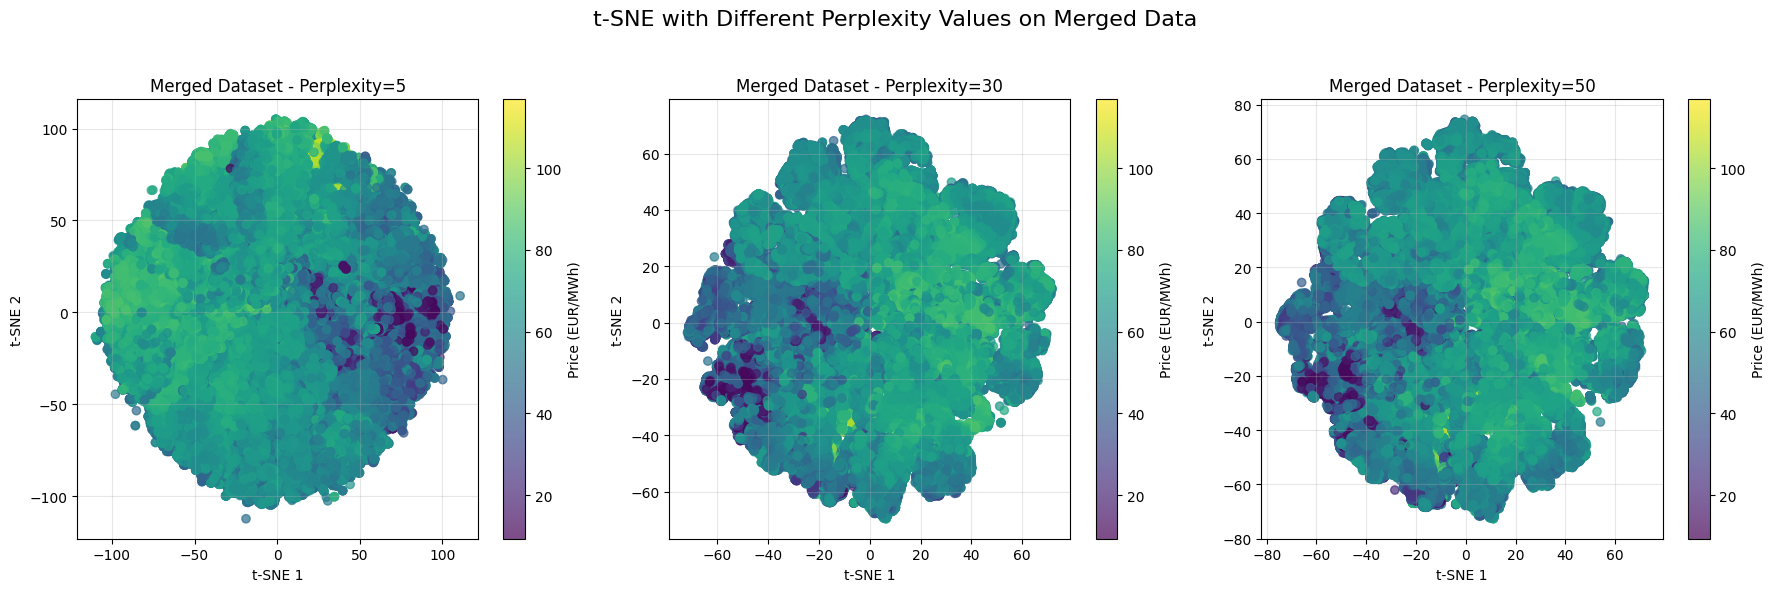

In [ ]:
def perform_tsne(X, dataset_name, target=None):
    import pandas as pd
    import numpy as np
    import warnings
    warnings.filterwarnings('ignore', category=FutureWarning)
    
    # Make a copy to avoid modifying original data
    X_clean = X.copy()
    print(f"Data types in {dataset_name} dataset:")
    print(X_clean.dtypes)
    
    # Convert all columns to float32 for GPU compatibility
    for col in X_clean.columns:
        if X_clean[col].dtype == 'object' or X_clean[col].dtype == 'bool':
            try:
                X_clean[col] = X_clean[col].astype(np.float32)
            except:
                print(f"Dropping column {col} due to type conversion failure")
                X_clean = X_clean.drop(columns=[col])
        else:
            # Convert all numeric columns to float32
            X_clean[col] = X_clean[col].astype(np.float32)
    
    # Check for and handle NaN values
    if X_clean.isna().any().any():
        print(f"Warning: NaN values found in {dataset_name} dataset. Filling with means.")
        X_clean = X_clean.fillna(X_clean.mean())
    
    from cuml.preprocessing import StandardScaler
    from cuml.manifold import TSNE
    
    # Save the original index to ensure we maintain row correspondence
    original_index = X_clean.index
    
    # Convert to numpy array first (more reliable than direct cuDF conversion)
    X_values = X_clean.values.astype(np.float32)
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_values)
    
    # Apply t-SNE with different perplexity values
    perplexities = [5, 30, 50]
    tsne_results = []
    
    for perp in perplexities:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=42)
        X_tsne = tsne.fit_transform(X_scaled)
        
        # Convert back to NumPy if needed
        if hasattr(X_tsne, 'get'):
            X_tsne = X_tsne.get()
        
        # Ensure we have the right number of rows
        print(f"TSNE result shape for perplexity {perp}: {X_tsne.shape}")
        
        tsne_results.append((perp, X_tsne))
    
    print(f"\n===== KẾT QUẢ t-SNE CHO DỮ LIỆU {dataset_name} =====")
    print(f"Original data shape: {X.shape}")
    print(f"Target shape: {target.shape if target is not None else 'None'}")
    
    return tsne_results

print("Running t-SNE on merged dataset...")
tsne_results_merged = perform_tsne(df_merged_clean, "MERGED", df_merged['price actual'])

# Visualize the results
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('t-SNE with Different Perplexity Values on Merged Data', fontsize=16)

# Merged dataset visualization
for i, (perp, X_tsne) in enumerate(tsne_results_merged):
    target_values = df_merged['price actual']
    # Ensure target values match the t-SNE output shape
    if len(target_values) != X_tsne.shape[0]:
        print(f"Length mismatch for perp={perp}: target={len(target_values)}, X_tsne={X_tsne.shape[0]}")
        color = np.arange(X_tsne.shape[0])  # Use index as color
    else:
        color = target_values  # Use price as color
        
    scatter = axs[i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=color, cmap='viridis', alpha=0.7)
    axs[i].set_title(f'Merged Dataset - Perplexity={perp}')
    axs[i].set_xlabel('t-SNE 1')
    axs[i].set_ylabel('t-SNE 2')
    axs[i].grid(True, alpha=0.3)
    
    # Add colorbar
    plt.colorbar(scatter, ax=axs[i], label='Price (EUR/MWh)')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Mô hình MultiLayer Perceptron

In [ ]:
# Import các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2

# Đảm bảo kết quả có thể tái tạo lại được
import tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)

2025-04-19 21:38:27.144538: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name="Model"):
    # Dự đoán
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Tính các chỉ số đánh giá
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    train_rmse = np.sqrt(train_mse)
    val_rmse = np.sqrt(val_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    print(f"===== {model_name} =====")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Validation MAE: {val_mae:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Validation R²: {val_r2:.4f}")
    
    # Trả về các chỉ số để so sánh
    return {
        'train_rmse': train_rmse, 'val_rmse': val_rmse,
        'train_mae': train_mae, 'val_mae': val_mae,
        'train_r2': train_r2, 'val_r2': val_r2
    }

def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.title(f'{title} - MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
def train_mlp_models(X, y, data_type):
    results = {}
    splits = [(0.8, 0.2), (0.7, 0.3), (0.6, 0.4)]  # Các tỉ lệ train:validation = 4:1, 7:3, 6:4
    
    for train_size, val_size in splits:
        # Chia dữ liệu
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=42)
        
        # Chuẩn hóa đặc trưng
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Xây dựng mô hình MLP
        model = Sequential([
            Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
        
        # Early stopping để tránh overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        
        # Huấn luyện mô hình
        history = model.fit(
            X_train_scaled, y_train,
            epochs=100,
            batch_size=32,
            validation_data=(X_val_scaled, y_val),
            callbacks=[early_stopping],
            verbose=1
        )
        
        # Đánh giá mô hình
        split_label = f"{int(train_size*10)}:{int(val_size*10)}"
        model_name = f"{data_type} Data - Split {split_label}"
        metrics = evaluate_model(model, X_train_scaled, y_train, X_val_scaled, y_val, model_name)
        
        # Lưu kết quả
        results[split_label] = {
            'model': model,
            'history': history,
            'metrics': metrics,
            'scaler': scaler
        }
        
        # Vẽ lịch sử huấn luyện
        plot_history(history, f"MLP with {data_type} Data - Split {split_label}")
    
    return results

/home/huy163/mlProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745073509.474493   14338 gpu_device.cc:2018] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1743 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/100


2025-04-19 21:38:32.012681: I external/local_xla/xla/service/service.cc:152] XLA service 0x7f796400ac80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-19 21:38:32.012726: I external/local_xla/xla/service/service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-04-19 21:38:32.072666: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745073512.269705   14567 cuda_dnn.cc:527] Loaded cuDNN version 90300
2025-04-19 21:38:34.172156: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_158', 96 bytes spill stores, 96 bytes spill loads



 52/877 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3243.1677 - mean_absolute_error: 54.8945

I0000 00:00:1745073517.966430   14567 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


867/877 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 751.7585 - mean_absolute_error: 18.8806

2025-04-19 21:38:42.231577: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_331', 4 bytes spill stores, 4 bytes spill loads

2025-04-19 21:38:43.293475: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_158', 252 bytes spill stores, 252 bytes spill loads



877/877 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 746.2899 - mean_absolute_error: 18.7918

2025-04-19 21:38:47.547235: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 16 bytes spill stores, 16 bytes spill loads

2025-04-19 21:38:47.731142: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 16 bytes spill stores, 16 bytes spill loads



877/877 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 745.7489 - mean_absolute_error: 18.7831 - val_loss: 102.4258 - val_mean_absolute_error: 8.0871
Epoch 2/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 98.6489 - mean_absolute_error: 7.9274 - val_loss: 95.4781 - val_mean_absolute_error: 7.8006
Epoch 3/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 89.1437 - mean_absolute_error: 7.5143 - val_loss: 87.4000 - val_mean_absolute_error: 7.4091
Epoch 4/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 80.1522 - mean_absolute_error: 7.0802 - val_loss: 80.8819 - val_mean_absolute_error: 7.1000
Epoch 5/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 73.3979 - mean_absolute_error: 6.7295 - val_loss: 75.4168 - val_mean_absolute_error: 6.8260
Epoch 6/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 67.7340 - mean_absolute_error: 6.4114 - val_loss: 71.0363 - val_mean_absolute_error: 6.5979
Epoch 7/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 63.2800 - mean_absolute_erro

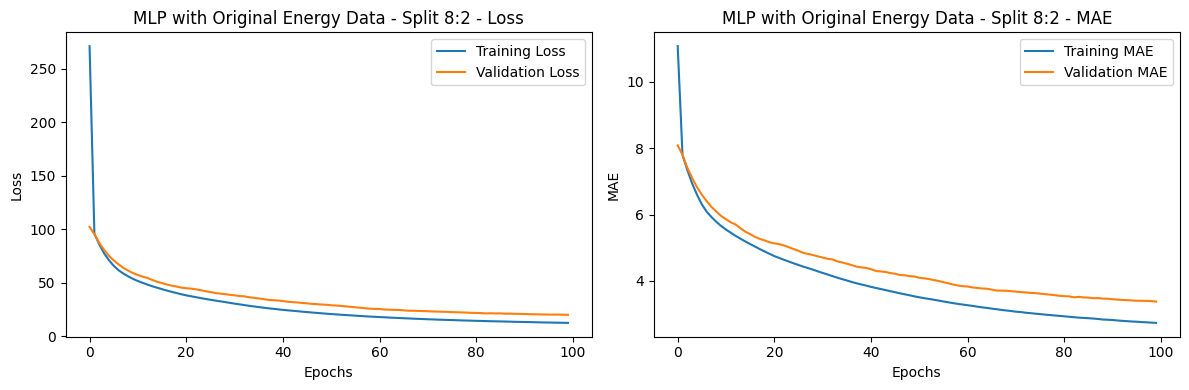

Epoch 1/100


/home/huy163/mlProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


756/767 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 988.4470 - mean_absolute_error: 22.4782

2025-04-19 21:47:05.563014: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 252 bytes spill stores, 252 bytes spill loads



767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 978.6475 - mean_absolute_error: 22.3238 - val_loss: 108.4465 - val_mean_absolute_error: 8.2459
Epoch 2/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 99.4044 - mean_absolute_error: 7.9282 - val_loss: 102.0010 - val_mean_absolute_error: 8.0081
Epoch 3/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 92.9750 - mean_absolute_error: 7.6775 - val_loss: 94.4496 - val_mean_absolute_error: 7.6733
Epoch 4/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 85.0222 - mean_absolute_error: 7.3096 - val_loss: 86.3654 - val_mean_absolute_error: 7.2825
Epoch 5/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 78.1154 - mean_absolute_error: 6.9701 - val_loss: 81.0907 - val_mean_absolute_error: 7.0085
Epoch 6/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 72.5931 - mean_absolute_error: 6.6716 - val_loss: 76.7733 - val_mean_absolute_error: 6.7864
Epoch 7/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 68.3708 - mean_absolute_err

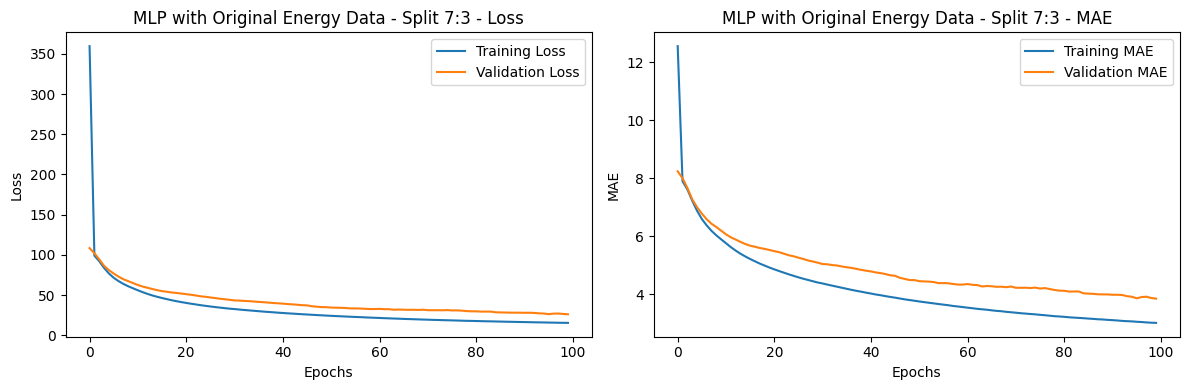

Epoch 1/100


/home/huy163/mlProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


657/658 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 896.4797 - mean_absolute_error: 21.3387

2025-04-19 21:55:09.256218: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_165', 16 bytes spill stores, 16 bytes spill loads

2025-04-19 21:55:11.171175: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_165', 16 bytes spill stores, 16 bytes spill loads



658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 895.6209 - mean_absolute_error: 21.3249

2025-04-19 21:55:15.679610: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 16 bytes spill stores, 16 bytes spill loads

2025-04-19 21:55:16.172015: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 16 bytes spill stores, 16 bytes spill loads



658/658 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 894.7646 - mean_absolute_error: 21.3110 - val_loss: 105.7565 - val_mean_absolute_error: 8.2064
Epoch 2/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 101.1867 - mean_absolute_error: 8.0160 - val_loss: 96.8343 - val_mean_absolute_error: 7.8468
Epoch 3/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 92.5383 - mean_absolute_error: 7.6678 - val_loss: 90.1838 - val_mean_absolute_error: 7.5537
Epoch 4/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 85.6724 - mean_absolute_error: 7.3536 - val_loss: 85.6428 - val_mean_absolute_error: 7.3364
Epoch 5/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 80.2851 - mean_absolute_error: 7.0905 - val_loss: 80.7253 - val_mean_absolute_error: 7.0919
Epoch 6/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 75.0645 - mean_absolute_error: 6.8331 - val_loss: 76.5119 - val_mean_absolute_error: 6.8806
Epoch 7/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 70.4989 - mean_absolute_err

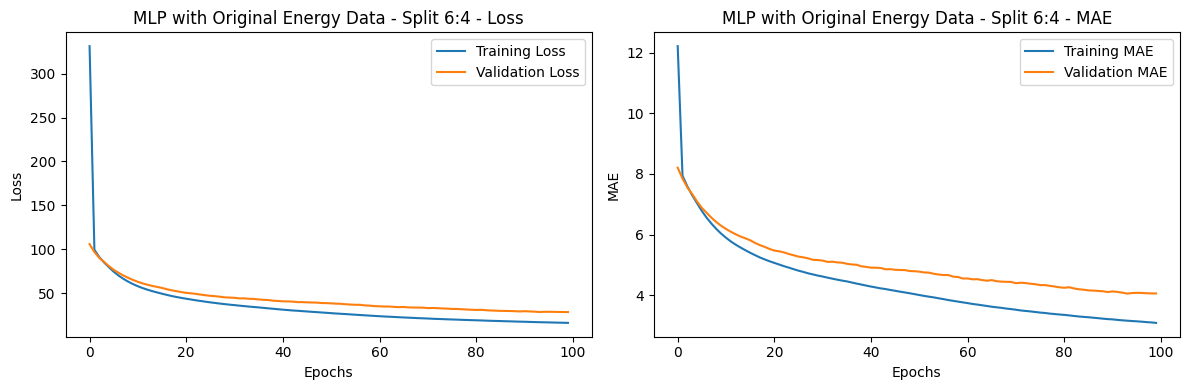

In [ ]:
original_results = train_mlp_models(X_energy, y_energy, data_type="Original Energy")

Dữ liệu gốc: (35064, 15), Dữ liệu sau PCA: (35064, 8)
Phương sai giữ lại: 0.7855
Epoch 1/100


/home/huy163/mlProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


877/877 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 866.5475 - mean_absolute_error: 20.5672 - val_loss: 119.6981 - val_mean_absolute_error: 8.7960
Epoch 2/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 117.6730 - mean_absolute_error: 8.6924 - val_loss: 109.0568 - val_mean_absolute_error: 8.4114
Epoch 3/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 105.0409 - mean_absolute_error: 8.2122 - val_loss: 102.6897 - val_mean_absolute_error: 8.1465
Epoch 4/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 97.6021 - mean_absolute_error: 7.8974 - val_loss: 99.1066 - val_mean_absolute_error: 7.9889
Epoch 5/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 93.9113 - mean_absolute_error: 7.7390 - val_loss: 96.2845 - val_mean_absolute_error: 7.8595
Epoch 6/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 91.2860 - mean_absolute_error: 7.6315 - val_loss: 94.0996 - val_mean_absolute_error: 7.7621
Epoch 7/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 89.1480 - mean_absolute_e

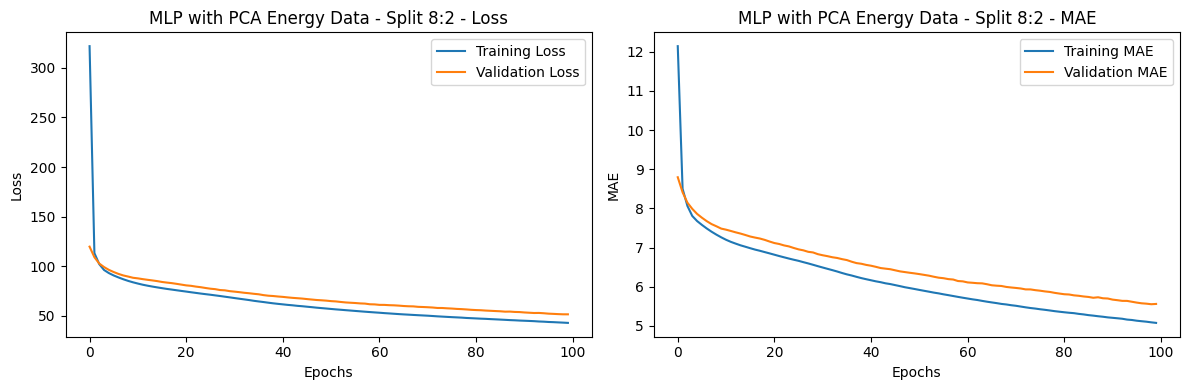

Epoch 1/100


/home/huy163/mlProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 940.6972 - mean_absolute_error: 21.9279 - val_loss: 125.2598 - val_mean_absolute_error: 8.9097
Epoch 2/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 116.4038 - mean_absolute_error: 8.6282 - val_loss: 114.2620 - val_mean_absolute_error: 8.5105
Epoch 3/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 105.6098 - mean_absolute_error: 8.2118 - val_loss: 106.9870 - val_mean_absolute_error: 8.2227
Epoch 4/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 98.8335 - mean_absolute_error: 7.9307 - val_loss: 101.9404 - val_mean_absolute_error: 8.0182
Epoch 5/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 94.7512 - mean_absolute_error: 7.7553 - val_loss: 98.7497 - val_mean_absolute_error: 7.8862
Epoch 6/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 92.1930 - mean_absolute_error: 7.6433 - val_loss: 96.7131 - val_mean_absolute_error: 7.8005
Epoch 7/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 90.3941 - mean_absolute_e

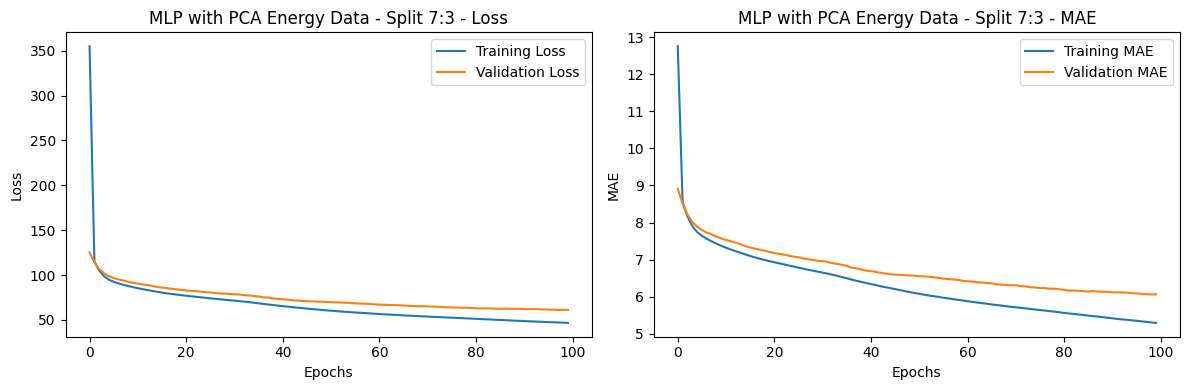

Epoch 1/100


/home/huy163/mlProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


658/658 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 1027.2561 - mean_absolute_error: 23.2379 - val_loss: 125.6441 - val_mean_absolute_error: 8.9540
Epoch 2/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 120.8227 - mean_absolute_error: 8.7885 - val_loss: 114.7646 - val_mean_absolute_error: 8.5758
Epoch 3/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 110.1015 - mean_absolute_error: 8.3956 - val_loss: 106.3021 - val_mean_absolute_error: 8.2695
Epoch 4/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 102.0533 - mean_absolute_error: 8.0950 - val_loss: 100.7187 - val_mean_absolute_error: 8.0523
Epoch 5/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 97.1198 - mean_absolute_error: 7.9026 - val_loss: 97.7345 - val_mean_absolute_error: 7.9245
Epoch 6/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 94.3544 - mean_absolute_error: 7.7842 - val_loss: 96.0920 - val_mean_absolute_error: 7.8549
Epoch 7/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 92.5450 - mean_a

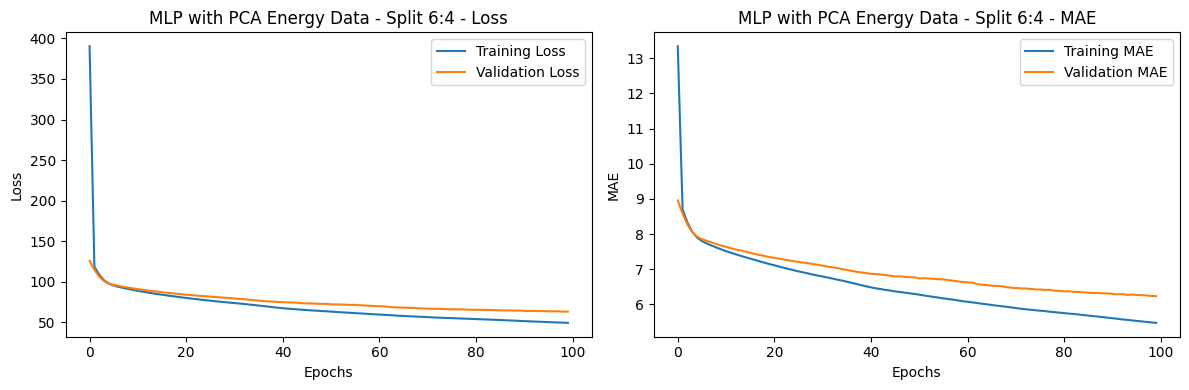

In [ ]:
scaler_pca = StandardScaler()
X_energy_scaled = scaler_pca.fit_transform(X_energy)

# Áp dụng PCA với 8 thành phần (số đã xác định trước đó)
pca = PCA(n_components=8)
X_energy_pca = pca.fit_transform(X_energy_scaled)

print(f"Dữ liệu gốc: {X_energy.shape}, Dữ liệu sau PCA: {X_energy_pca.shape}")
print(f"Phương sai giữ lại: {np.sum(pca.explained_variance_ratio_):.4f}")

# Huấn luyện MLP trên dữ liệu đã giảm chiều với PCA
pca_results = train_mlp_models(X_energy_pca, y_energy, data_type="PCA Energy")

In [37]:
from sklearn.manifold import TSNE

# Chuẩn bị dữ liệu t-SNE (sử dụng perplexity=30 đã dùng trước đó)
# Chuẩn hóa dữ liệu
scaler_tsne = StandardScaler()
X_energy_scaled_tsne = scaler_tsne.fit_transform(X_energy)

# Áp dụng t-SNE, giảm xuống còn 2 chiều
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_energy_tsne = tsne.fit_transform(X_energy_scaled_tsne)

print(f"Dữ liệu gốc: {X_energy.shape}, Dữ liệu sau t-SNE: {X_energy_tsne.shape}")

# Huấn luyện MLP trên dữ liệu đã giảm chiều với t-SNE
tsne_results = train_mlp_models(X_energy_tsne, y_energy, data_type="t-SNE Energy")

Dữ liệu gốc: (35064, 15), Dữ liệu sau t-SNE: (35064, 2)


NameError: name 'train_mlp_models' is not defined